# Import

In [1]:
import os
import time
import json
import random
import datetime
import numpy as np
import pandas as pd
from random import *

from IPython.display import display

from pathlib import Path
from tyssue import config
from tyssue import Sheet
from tyssue.io import hdf5
from tyssue.io.hdf5 import load_datasets
from tyssue.topology import all_rearangements
from tyssue.core.history import HistoryHdf5
from tyssue.dynamics import SheetModel as basemodel
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.draw.ipv_draw import sheet_view as ipv_draw 

from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.sheet.apoptosis_events import apoptosis
from tyssue.behaviors.sheet.basic_events import reconnect

from tyssue.utils import to_nd

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')

import ipyvolume as ipv

In [2]:
from polarity.dynamics import model
from polarity.apoptosis import apoptosis, apoptosis_patterning
from polarity.dynamics import EllipsoidLameGeometry as geom
from polarity.toolbox import (init,
                              define_fold_position,
                              apoptosis_ventral,
                              apoptosis_lateral,
                              apoptosis_dorsal,
                              define_polarity
                             )
from tyssue.dynamics import units, effectors, model_factory
from polarity.dynamics import RadialTension, BarrierElasticity, PerimeterElasticity

from polarity.delamination import delamination

# Working directory

In [3]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/')

today = datetime.date.today().strftime('%Y%m%d')
sim_save_dir = SIM_DIR/f'{today}-QSSolver-polarized_clonehomogenous'

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

# Define solver, model and process settings

In [4]:
solver = QSSolver(with_t1=False, with_t3=False, with_collisions=False)

model = model_factory(
    [
        BarrierElasticity,
        RadialTension,
        PerimeterElasticity,
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
    ], effectors.FaceAreaElasticity)

In [5]:
apopto_pattern_kwargs = {'t':0.,
                      'dt':1.,
                     'time_of_last_apoptosis':30.}
# apoptose
apoptosis_settings = {
        "critical_area_pulling":10,
        "critical_area": 0.5,
        "contract_rate": 1.08,
        "basal_contract_rate": 1.01,
        "contract_neighbors": True,
        "contract_span": 3,
        "radial_tension": 30.,
        "max_traction": 30.,
        "current_traction":0.,
        "geom": geom,
    }

# pour la propagation aux voisins
contraction_lt_kwargs = {
    'face_id':-1,
    'face':-1,
    'shrink_rate':1.05,
    'critical_area': 5.,
    "contraction_column": "line_tension",
    "model":model,
    }

 # Add events to limit rosette 
rosette_kwargs={
    'threshold_length':1e-6,
    'p_4':0.9,
    'p_5p':0.9}

# clone perturbateur
delaminate_settings = {
        'radial_tension':30,
        "contract_rate": 1.08,
        "critical_area_pulling":15,
        "critical_area": 1e-2,
        'current_traction': 0,
        'max_traction': 150,
        'contract_neighbors': True,
        'contract_span': 3,
        'basal_contract_rate': 1.01,
        'geom': geom,
        'model':model}


# Initiate Tissue

In [6]:
sheet = init(hf5_filename='super_egg.hf5',
             json_filename = 'superegg_final.json')

sheet.settings['geometry'] = "spherical"
sheet.settings['lumen_vol_elasticity'] = 1.e-5
sheet.settings['barrier_ray'] = 100

sheet.vert_df['barrier_elasticity'] = 280.0

# A définir en fonction de l'angle de la jonction
sheet.edge_df['weighted'] = 1.
sheet.edge_df['weighted_length'] = sheet.edge_df.weighted * sheet.edge_df.length

sheet.face_df['apoptosis'] = 0
sheet.face_df['current_traction'] = 0.0
sheet.face_df['radial_tension'] = 0.0
sheet.face_df['prefered_perimeter'] = 2*np.sqrt(sheet.face_df['prefered_area'])
sheet.face_df['perimeter_elasticity'] = 10.
sheet.face_df['area_elasticity'] = 1.



sheet.settings['apopto_pattern_kwargs'] = apopto_pattern_kwargs
sheet.settings['apoptosis'] = apoptosis_settings
sheet.settings['rosette_kwargs'] = rosette_kwargs
sheet.settings['contraction_lt_kwargs'] = contraction_lt_kwargs
sheet.settings['delaminate_setting'] = delaminate_settings

geom.update_all(sheet)

In [7]:
define_fold_position(sheet, fold_number = 1, position=[-8, 8])
sheet.face_df.apoptosis = 0

"""apoptosis_ventral(sheet, 1)
apoptosis_lateral(sheet, 1)
apoptosis_dorsal(sheet, 1)

ipv.clear()
# code couleur profondeur du tissu
fig, mesh = sheet_view(sheet, mode="3D", coords=['z', 'x', 'y'],
                   edge={'color':'lightslategrey',
                         'visible':True},
                   face={'color': sheet.face_df.apoptosis,
                        'colormap':'Reds',
                        'visible':True})
fig

print(len(sheet.face_df[sheet.face_df.fold>0]))
print(len(sheet.face_df[sheet.face_df.apoptosis>0]))"""


l = [   5, 37,   71,   72, 95,  241,  384,  502,
     559,  653,  696,  706,  776, 848,  958,  985, 1008, 1075,
    1135, 1215, 1264, 1312, 1330, 1393, 1416, 1424, 1429, 1435, 1452,
    1466, 1491, 1543, 1544, 1583]
for i in l :
    sheet.face_df.loc[i, 'apoptosis']=1

In [8]:
sheet.face_df['is_mesoderm']=0

sheet.face_df.loc[330, 'is_mesoderm']=1

/home/admin-suz/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


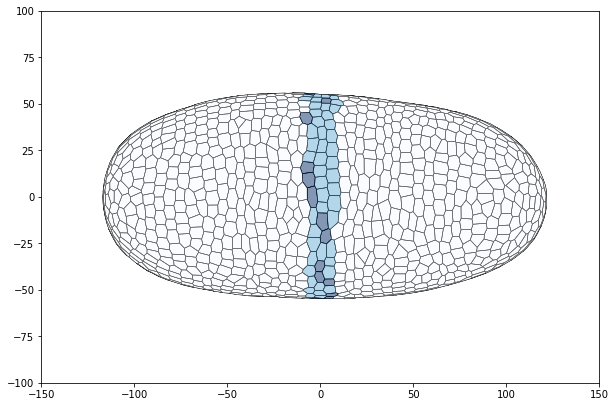

In [9]:
def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color':'k'
            #'color': sheet.edge_df['stress'],
            #"colormap":'bwr',
            #'color_range':(-20,20)
        },
        'face': {
            'visible': True,
            'color':sheet.face_df.apoptosis+sheet.face_df.fold,
            'colormap': 'Blues',
            'alpha':0.5

        },
        'vert':{
            'visible':False,
            's':100,
            'alpha': 0.3,
            'zorder': 2,


        }

    }
    return specs

sheet_=sheet.extract_bounding_box(y_boundary=(0,150))
fig, ax = sheet_view(sheet_, ['z', 'x'], mode="2D", **draw_specs(sheet_))
ax.set_ylim(-100,100)
ax.set_xlim(-150,150)

fig.set_size_inches(10,10)

In [10]:
"""def define_polarity_aleatory(sheet, parallel_weighted, perpendicular_weighted):
    # Angle θ of the source in the cylindrical coordinate system
    theta = np.arctan2(sheet.edge_df["sy"], sheet.edge_df["sx"],)
    cost, sint = np.cos(-theta), np.sin(-theta)

    # One rotation matrix per edge
    rot_mat = np.array(
        [[cost, sint],
         [-sint, cost]]
    )
    #print('Shape of rotation matrices', rot_mat.shape)

    # We want to get the edge coordinates w/r to θ
    dx_dy = sheet.edge_df[['dx', 'dy']].to_numpy()
    sheet.edge_df['dx_r'] = sheet.edge_df['dx'].copy()
    sheet.edge_df['dy_r'] = sheet.edge_df['dy'].copy()

    # numpy einsum magic (need lots of trial and error :/)
    sheet.edge_df[['dx_r', 'dy_r']] = np.einsum('jik, ki-> kj', rot_mat, dx_dy)

    # φ is the angle we want
    sheet.edge_df["phi"] = np.arctan2(
        sheet.edge_df['dz'], sheet.edge_df['dy_r'])

    sheet.face_df['clone']=0
    
    p=1652
    k=826
    T=np.arange(1,p+1,1) # initialisation de l'urne
    for i in range(k): # tirage des k numéros
        d=randint(1,p)
        sheet.face_df.loc[d, 'clone']=1
        for index in sheet.edge_df[sheet.edge_df.face==d].index:
            if (sheet.edge_df.loc[index, 'phi'] > np.pi / 3) and (sheet.edge_df.loc[index, 'phi'] < 2 * np.pi / 3):
                sheet.edge_df.loc[index, "weighted"] = perpendicular_weighted
            else:
                sheet.edge_df.loc[index, "weighted"] = parallel_weighted

"""

define_polarity(sheet, 1, 0.5)
print(sheet.edge_df.weighted.unique())
geom.normalize_weights(sheet)

[1.  0.5]


Int64Index([1991, 3323, 5742, 5750, 5754, 8798], dtype='int64', name='edge')
Int64Index([306, 3322, 8011, 8028, 8032, 9048], dtype='int64', name='edge')
Int64Index([279, 2465, 7309, 8010, 8014, 8031], dtype='int64', name='edge')
Int64Index([304, 315, 3325, 8029, 8186, 9689], dtype='int64', name='edge')
Int64Index([1871, 1988, 4122, 4126, 5752, 5755], dtype='int64', name='edge')
Int64Index([307, 5753, 6404, 6407, 7549, 9688, 9874], dtype='int64', name='edge')
Int64Index([298, 4128, 7164, 7167, 8764, 9735], dtype='int64', name='edge')
Int64Index([302, 3324, 7162, 8030, 8033], dtype='int64', name='edge')
Int64Index([303, 7163, 8184, 8187, 8765, 9801, 9875], dtype='int64', name='edge')


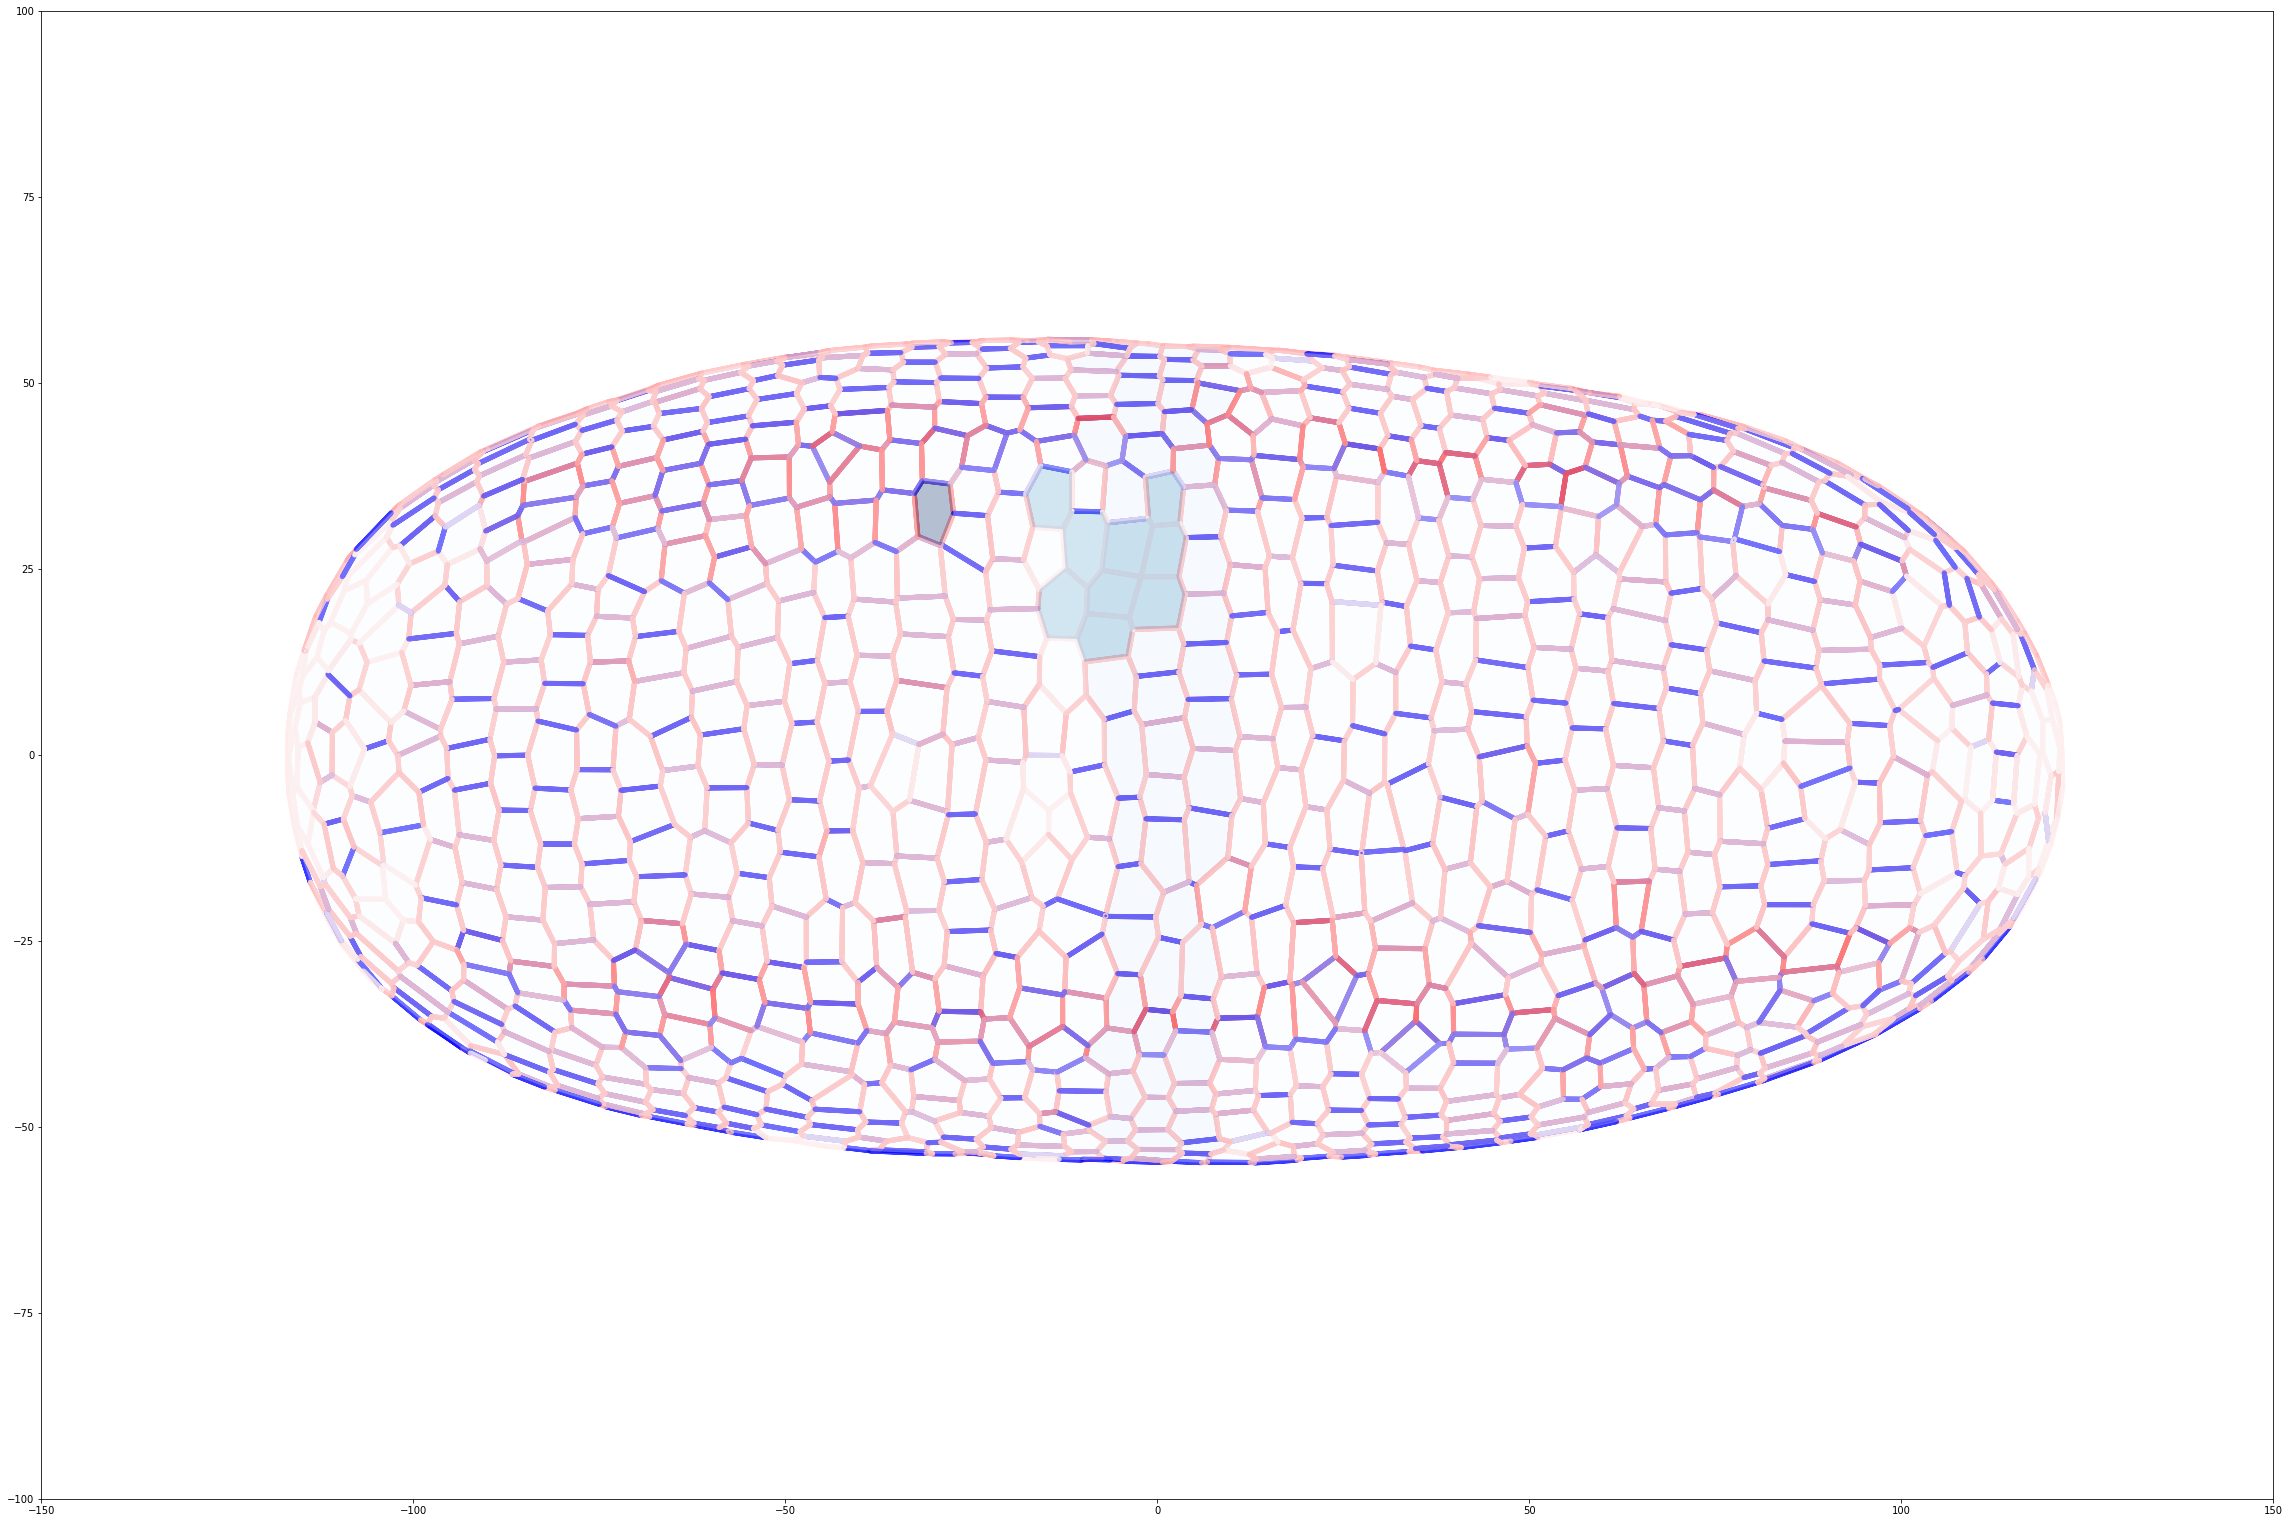

In [11]:
#define homogenous clone
f_index = sheet.face_df.loc[sheet.face_df[(sheet.face_df.x>15) & (sheet.face_df.x<35) &
                 (sheet.face_df.y>15) & (sheet.face_df.y<55)&
                 (sheet.face_df.z>-15) & (sheet.face_df.z<2)].index].index

sheet.face_df['clone']=0
for i in f_index:
    sheet.face_df.loc[i, 'clone']=1
    
    edge = sheet.edge_df[sheet.edge_df.face == i].index
    print(edge)
    for e in edge:
        sheet.edge_df.loc[e, "weighted"] = 1
        sheet.edge_df.loc[sheet.edge_df.loc[e, 'edge_o'], "weighted"]=1
    
    
def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color': sheet.edge_df['weighted'],
            'colormap':'bwr',
            'width':5,
            #'color_range':(-20,20)
        },
        'face': {
            'visible': True,
            'color':sheet.face_df.clone*10+sheet.face_df.fold*2+sheet.face_df.is_mesoderm*20,
            'colormap': 'Blues',
            'alpha':0.3

        },
        'vert':{
            'visible':False,
            's':100,
            'alpha': 0.3,
            'zorder': 2,


        }

    }
    return specs


sheet_=sheet.extract_bounding_box(y_boundary=(0,150))
fig, ax = sheet_view(sheet_, ['z', 'x'], mode="2D", **draw_specs(sheet_))
ax.set_ylim(-100,100)
ax.set_xlim(-150,150)

fig.set_size_inches(40,40)

In [12]:
res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})
print(res)

      fun: 1512.4032804467931
 hess_inv: <9900x9900 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.54562469e-04, -1.47542447e-04,  3.98954975e-05, ...,
       -1.94688613e-04,  2.25171944e-04, -7.77400563e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 377
      nit: 284
   status: 0
  success: True
        x: array([ -7.78482805,  56.35011258, -14.26708714, ...,  45.46165167,
        23.29064223, -64.60323743])


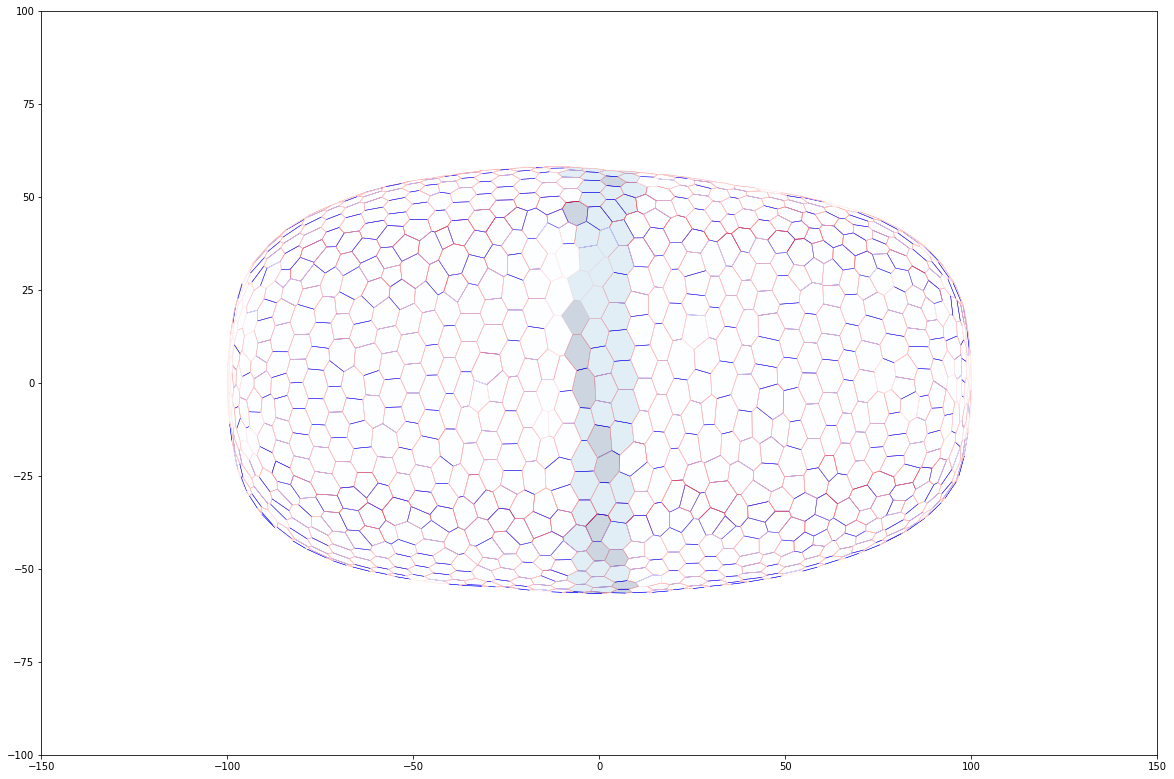

In [13]:
def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color': sheet.edge_df['weighted'],
            'colormap':'bwr',
            #'color_range':(-20,20)
        },
        'face': {
            'visible': True,
            'color':sheet.face_df.apoptosis+sheet.face_df.fold,
            'colormap': 'Blues',
            'alpha':0.2

        },
        'vert':{
            'visible':False,
            's':100,
            'alpha': 0.3,
            'zorder': 2,


        }

    }
    return specs


sheet_=sheet.extract_bounding_box(y_boundary=(0,150))
fig, ax = sheet_view(sheet_, ['z', 'x'], mode="2D", **draw_specs(sheet_))
ax.set_ylim(-100,100)
ax.set_xlim(-150,150)

fig.set_size_inches(20,20)

In [14]:
#sheet.face_df[sheet.face_df.clone==1]
sheet.edge_df[sheet.edge_df.face.isin(sheet.face_df[sheet.face_df.clone==1].index)].index

Int64Index([ 279,  298,  302,  303,  304,  306,  307,  315, 1871, 1988, 1991,
            2465, 3322, 3323, 3324, 3325, 4122, 4126, 4128, 5742, 5750, 5752,
            5753, 5754, 5755, 6404, 6407, 7162, 7163, 7164, 7167, 7309, 7549,
            8010, 8011, 8014, 8028, 8029, 8030, 8031, 8032, 8033, 8184, 8186,
            8187, 8764, 8765, 8798, 9048, 9688, 9689, 9735, 9801, 9874, 9875],
           dtype='int64', name='edge')

In [15]:

for i in sheet.edge_df[sheet.edge_df.face.isin(sheet.face_df[sheet.face_df.clone==1].index)].index:
    print(sheet.edge_df.loc[i, 'face'],
          sheet.edge_df.loc[i, 'weighted_length'], 
          sheet.edge_df.loc[sheet.edge_df.loc[i,'edge_o'], "weighted_length"])

484 5.028899211789723 4.029495022894783
1405 2.0251944054256876 4.037734410853394
1569 5.048316688648509 7.5282536246132095
1597 7.566961477470933 6.82065902278562
658 5.73518857737913 5.731862339912524
194 4.968099113582302 3.9426199894225578
1260 5.129997533037134 3.7921835688431127
658 1.7989342405964903 4.826978229588247
1135 6.144664285714188 1.8394177634949402
1135 1.7989342405964903 5.133519029266949
3 5.73518857737913 4.162227885607423
484 2.9149800783795317 4.00815076000625
194 2.488687011869892 5.731862339912524
3 2.488687011869892 4.162227885607423
1569 2.533934966387973 7.5282536246132095
658 2.533934966387973 7.5282536246132095
1135 5.028782219022864 4.056050412540074
1135 2.1841602295753173 1.8394177634949402
1405 6.036127973416722 4.037734410853394
3 4.845765521673351 6.387045527923757
3 3.0911728481896072 4.056050412540074
1135 5.561660684031446 5.133519029266949
1260 5.561660684031446 4.826978229588247
3 5.57892008791866 1.8394177634949402
1135 5.57892008791866 1.83941

In [16]:
def run_sim(sim_save_dir, sheet2, constriction, radial_tension, iteration=0):
    
    # without copy, dataframe is on read only... 
    sheet = sheet2.copy()
    
    dirname = '{}_constriction_{}_radialtension{}'.format(
        constriction,radial_tension, iteration)
    dirname = os.path.join(sim_save_dir, dirname)
    
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass
    
    # Add some information to the sheet and copy initial sheet
    sheet.face_df['id'] = sheet.face_df.index.values

    # Initiate history
    history = HistoryHdf5(sheet, 
                          extra_cols={"face": sheet.face_df.columns,
                                      "edge": list(sheet.edge_df.columns),
                                      "vert": list(sheet.vert_df.columns)},
                         hf5file=os.path.join(dirname, 'out.hf5'))
    
    # Initiate manager
    manager = EventManager('face')
    
    # Update kwargs...
    sheet.settings['apoptosis'].update(
                    {
                    'contract_rate':constriction,
                    'radial_tension':radial_tension
                    })
    
    #save settings
    pd.Series(sheet.settings).to_csv(os.path.join(dirname, 'settings.csv'))
    
    manager.append(reconnect, **sheet.settings['rosette_kwargs'])
    manager.append(apoptosis_patterning, **sheet.settings['apopto_pattern_kwargs'])

    t = 0.
    stop = 150.
    # Run simulation
    while t < stop:        

        if t == 5 : 
            for i in sheet.face_df[sheet.face_df.is_mesoderm==1].index:
                delamination_kwargs = sheet.settings['delaminate_setting'].copy()
                delamination_kwargs.update(
                        {
                            "face_id": i,
                            #"radial_tension": radial_tension,
                            "radial_tension":200,
                            "contract_rate": 1.08,
                            "max_traction":90,
                            "current_traction":0,
                        }
                    )
                manager.append(delamination, **delamination_kwargs)
        
        # Reset radial tension at each time step
        sheet.vert_df.radial_tension = 0.

        manager.execute(sheet)
        res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})
        print(res.success)
        # add noise on vertex position to avoid local minimal.
        sheet.vert_df[
            ['x', 'y']] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
        geom.update_all(sheet)
        
        
        # Save result in each time step.
        figname = os.path.join(
            dirname, 'invagination_{:04.0f}.png'.format(t))
        hdfname = figname[:-3] + 'hf5'        
        hdf5.save_datasets(hdfname, sheet)

        history.record(time_stamp=float(t))

        manager.update()
        t += 1.
    
    
    
    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')

In [17]:
from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))
num_cores = multiprocessing.cpu_count()
#""" Initiale find minimal energy
# To be sure we are at the equilibrium before executing simulation 
# (it will be done only once if multiprocessing...)
#res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})

radial_tension = [50.]

contractility_percent = [ 8 ]
contractility_rate = [1+c/100 for c in contractility_percent]


contractility_rate, radial_tension = np.meshgrid(contractility_rate, radial_tension)

results = Parallel(n_jobs=2)(delayed(run_sim)(
    sim_save_dir, sheet, c, rd, 0) 
                 for  c, rd in zip(contractility_rate.ravel(), radial_tension.ravel()))

global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

start : 2019-11-05 11:11:38.023733
end : 2019-11-05 14:11:08.537249
Duree totale d execution : 
		
2:59:30.513516
